In [ ]:
# importing libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from wordcloud import WordCloud, STOPWORDS

from mlxtend.frequent_patterns import association_rules, apriori

import warnings
warnings.filterwarnings('ignore')

---
# <font color = 'orange'>Reading and Cleaning

In [ ]:
# reading the data
data = pd.read_csv('/kaggle/input/the-bread-basket/bread basket.csv')

# looking top 10 rows
data.head(10)

In [ ]:
# looking the bigger picture
data.info()

- There is no missing values in the data
- Converting 'date_time' column into datetime
- Create some extra features from date_time column for analysis purpose

In [ ]:
# Converting the 'date_time' column into the right format
data['date_time'] = pd.to_datetime(data['date_time'])

In [ ]:
data.head()

In [ ]:
# Count of unique customers
data.Transaction.nunique()

In [ ]:
# Extracting date
data['date'] = data['date_time'].dt.date
data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d')

# Extracting time
data['time'] = data['date_time'].dt.time

# Extracting month and replacing it with text
data['month'] = data['date_time'].dt.month
data['month'] = data['month'].replace((1,2,3,4,5,6,7,8,9,10,11,12), 
                                          ('January','February','March','April','May','June','July','August',
                                          'September','October','November','December'))

# Extracting hour
data['hour'] = data['date_time'].dt.hour
# Replacing hours with text
hour_in_num = (1,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23)
hour_in_obj = ('1-2','7-8','8-9','9-10','10-11','11-12','12-13','13-14','14-15',
               '15-16','16-17','17-18','18-19','19-20','20-21','21-22','22-23','23-24')
data['hour'] = data['hour'].replace(hour_in_num, hour_in_obj)

# Extracting weekday and replacing it with text
data['weekday'] = data['date_time'].dt.weekday
data['weekday'] = data['weekday'].replace((0,1,2,3,4,5,6), 
                                          ('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'))

# dropping date_time column
data.drop('date_time', axis = 1, inplace = True)

data.head()

In [ ]:
# cleaning the item column
data['Item'] = data['Item'].str.strip()
data['Item'] = data['Item'].str.lower()

In [ ]:
# looking 10 rows of data
data.head(10)

---
# <font color = 'orange'>Exploratory Data Analysis

In [ ]:
all_headlines = ' '.join(data['Item'])
wordcloud = WordCloud(width = 3000, height = 2000, background_color = 'white', 
                      collocations = False).generate((all_headlines))
plt.figure(figsize = (15, 5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### Observation
The above word cloud is formed based upon the item list in the dataset. Larger the frequency of the item, larger the size of the word.<br>
We seeing that **coffee**, **bread**, **tea**, **cake**, **pastry**, **sandwich** are bigger in sizes. As the frequency of item is lower the size of word is also smaller.

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x = data.Item.value_counts().head(20).index, y = data.Item.value_counts().head(20).values, color='pink')
plt.xlabel('Items', size = 15)
plt.xticks(rotation=45)
plt.ylabel('Count of Items', size = 15)
plt.title('Top 20 Items purchased by customers', color = 'green', size = 20)
plt.show()

#### Observation:
1. Around 48% of transactions contains `cofffee`, 33% contains `bread`, 14% contains `tea` and 10% contains `cake`.
2. Together coffee and bread 9%, coffee and tea 5%, coffee and cake 5%, bread and tea 3%, bread and cake 2%, tea and cake 2%.

In [ ]:
monthTran = data.groupby('month')['Transaction'].count().reset_index()
monthTran.loc[:,"monthorder"] = [4,8,12,2,1,7,6,3,5,11,10,9]
monthTran.sort_values("monthorder",inplace=True)


plt.figure(figsize=(12,5))
sns.barplot(data = monthTran, x = "month", y = "Transaction")
plt.xlabel('Months', size = 15)
plt.ylabel('Orders per month', size = 15)
plt.title('Number of orders received each month', color = 'green', size = 20)
plt.show()

#### Observation:
Most orders are from the `winter months` i.e. people order more in winters.

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x = data.period_day.value_counts().index, y = data.period_day.value_counts().values, color='pink')
plt.xlabel('Period', size = 15)
plt.ylabel('Orders per period', size = 15)
plt.title('Number of orders received in each period of a day', color = 'green', size = 20)
plt.show()

#### Observation:
More than 50% of orders came in afternoon i.e. between 12 noon to 5 pm and specifically between 12-2 it was 48%.

In [ ]:
hourTran = data.groupby('hour')['Transaction'].count().reset_index()
hourTran.loc[:,"hourorder"] = [1,10,11,12,13,14,15,16,17,18,19,20,21,22,23,7,8,9]
hourTran.sort_values("hourorder",inplace=True)

plt.figure(figsize=(12,5))
sns.barplot(data = hourTran, x = "hour", y = "Transaction")
plt.xlabel('Hours', size = 15)
plt.ylabel('Orders each hour', size = 15)
plt.title('Count of orders received each hour', color = 'green', size = 20)
plt.show()

#### Observation:
Maxium number of orders came in morning 11-12. But from previous graph the percentage of order was maxium in afternoon and we can also see in this figure that between 12-5 the bars are high.

In [ ]:
weekTran = data.groupby('weekday')['Transaction'].count().reset_index()
weekTran.loc[:,"weekorder"] = [5,1,6,7,4,2,3]
weekTran.sort_values("weekorder",inplace=True)


plt.figure(figsize=(10,5))
sns.barplot(data = weekTran, x = "weekday", y = "Transaction", color='pink')
plt.xlabel('Weekdays', size = 15)
plt.ylabel('Orders per weekday', size = 15)
plt.title('Number of orders received each of the weekday', color = 'green', size = 20)
plt.show()

#### Observations:
Friday, Saturday and Sunday was the days where orders are higher than rest of the days. Together these three days account for 48% of total order received in a week. 

In [ ]:
data.groupby('date')['Transaction'].count().plot(kind="line",figsize=(15,7),color='purple')
plt.xlabel('Date', size = 15)
plt.ylabel('Count of Transaction', size = 15)
plt.hlines(y = 129, color='red', xmin=data['date'].min(), xmax=data['date'].max(),
           linestyles='dashed', label='Mean:129')
plt.title('Transactions per day',  color = 'green', size = 20)
plt.legend(fontsize='large')
plt.show()

In [ ]:
# getting dates where number of transactions are more than 200
dates = data.groupby('date')['Transaction'].count().reset_index()
dates = dates[dates['Transaction']>=200].sort_values('date').reset_index(drop=True)

dates = pd.merge(dates,data[['date','weekday']],on='date', how='inner')
dates.drop_duplicates(inplace=True)
dates

#### Obervation:
1. The mean number of orders per day was around 129. We can see a lot of fluctuation in the data. It is also noted that on `1st Jan'2017 the store was closed` as there was no order on that day.
2. The above table shows days where the number of transactions are more than 200 and it is been observed that 80% of them are weekends.

In [ ]:
df = data.groupby(['period_day','Item'])['Transaction'].count().reset_index().sort_values(['period_day','Transaction'],ascending=False)
day = ['morning','afternoon','evening','night']

plt.figure(figsize=(15,8))
for i,j in enumerate(day):
    plt.subplot(2,2,i+1)
    df1 = df[df.period_day==j].head(10)
    sns.barplot(data=df1, y=df1.Item, x=df1.Transaction, color='pink')
    plt.xlabel('')
    plt.ylabel('')
    plt.title('Top 10 items people like to order in "{}"'.format(j), size=13)

plt.show()

----
# <font color = 'orange'>Market Basket Analysis
Also known as **Association Rule Analysis**<br>
Technique to solve MBA is **Apriori Algorithm**

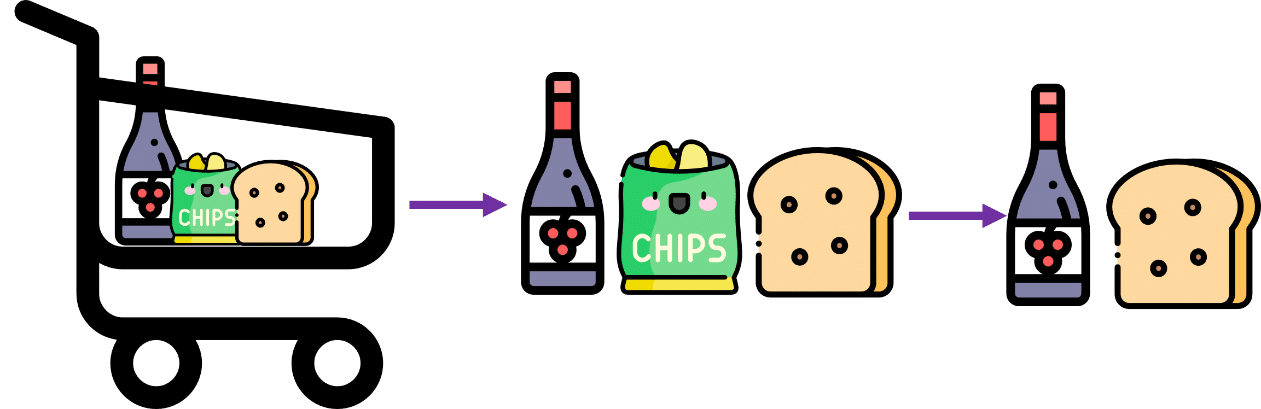

### <font color = 'blue'>What is Market Basket Analysis?</font>
- MARKET Basket Analysis (MBA) is an association analysis and is a popular data mining technique. It’s a kind of knowledge discovery in data (KDD) and this technique can be applied in various fields of work.
- In market basket analysis (also called **association analysis** or **frequent itemset mining**), you analyze purchases that commonly happen together. For example, people who buy bread and peanut butter also buy jelly. Or people who buy shampoo might also buy conditioner. What relationships there are between items is the target of the analysis. Knowing what your customers tend to buy together can help with marketing efforts and store/website layout.
- Market Basket Analysis is one of the key techniques used by large retailers to uncover associations between items. It works by looking for combinations of items that occur together frequently in transactions. To put it another way, `it allows retailers to identify relationships between the items that people buy`.
- The discovery of these associations can help retailers develop marketing strategies by gaining insight into which items are frequently purchased together by customers. The strategies may include:
    1. Changing the store layout according to trends
    2. Customer behavior analysis
    3. Catalog design
    4. Cross marketing on online stores
    5. What are the trending items customers buy
    6. Customized emails with add-on sales etc..

### <font color = 'blue'>Apriori Algorithm</font>
1. Apriori algorithm is given by R. Agrawal and R. Srikant in 1994 for finding frequent itemsets in a dataset for boolean association rule. Name of the algorithm is Apriori because it uses prior knowledge of frequent itemset properties.
2. Apriori algorithm assumes that any subset of a frequent itemset must be frequent.The value of “frequent itemset” > than a threshold value(i.e. support). Its the algorithm behind Market Basket Analysis.
3. Apriori assumes that: **All subsets of a frequent itemset must be frequent(Apriori propertry).If an itemset is infrequent, all its supersets will be infrequent.** Say, a transaction containing {Grapes, Apple, Mango} also contains {Grapes, Mango}. So, according to the principle of Apriori, if {Grapes, Apple, Mango} is frequent, then {Grapes, Mango} must also be frequent.

### <font color = 'blue'>The analysis of the association rules depend on five measures (but only first three are widely used)</font>
1. `Support`: Support of the item x is nothing but the ratio of the number of transactions in which the item x appears to the total number of transactions. 
    - **Support(Item A) = (Transactions containing Item A) / (Total transactions), range:[0,1]**
2. `Confidence`: Confidence refers to the likelihood that an item B is also bought if item A is bought. It can be calculated by finding the number of transactions where A and B are bought together, divided by total number of transactions where A is bought. A confidence of 0.5 would mean that in 50% of the cases where A were purchased, the purchase also included B. For product recommendation, a 50% confidence may be perfectly acceptable but in a medical situation, this level may not be high enough.
    - **Confidence(A → B) = (Transactions containing both (A and B)) / (Transactions containing A), range:[0,1]**
3. `Lift`: Lift(A → B) refers to the increase in the ratio of sale of B when A is sold. Lift (A → B) is nothing but the ‘interestingness’ or the likelihood of the item B being purchased when the item A is sold. A Lift of 1 means there is no association between products A and B. Lift of greater than 1 means products A and B are more likely to be bought together. Finally, Lift of less than 1 refers to the case where two products are unlikely to be bought together.
    - **Lift(A → B) = (Confidence (A → B)) / (Support (B)), range:[0,∞]**
4. `Leverage`: Leverage computes the difference between the observed frequency of A and C appearing together and the frequency that would be expected if A and C were independent. An leverage value of 0 indicates independence.
    - **levarage(A → C) = support(A → C) − support(A)×support(C), range:[−1,1]**
5. `Conviction`: A high conviction value means that the consequent is highly depending on the antecedent. For instance, in the case of a perfect confidence score, the denominator becomes 0 (due to 1 - 1) for which the conviction score is defined as 'inf'.Similar to lift, if items are independent, the conviction is 1.
    - **conviction(A → C) = (1−support(C)) / (1−confidence(A → C)), range:[0,∞]**

In [ ]:
# grouping the data with respect to transaction and item and look at the count of each item in each transaction

df = data.groupby(['Transaction','Item'])['Item'].count().reset_index(name='Count')
df

In [ ]:
# making a mxn matrice where m=transaction and n=items and each row represents whether the item was in the transaction or not

my_basket = df.pivot_table(index='Transaction', columns='Item', values='Count', aggfunc='sum').fillna(0)
# df.groupby(['Transaction','Item'])['Count'].sum().unstack().reset_index().fillna(0).set_index('Transaction')

my_basket.head()

In [ ]:
# making a function which returns 0 or 1
# 0 means item was not in that transaction, 1 means item present in that transaction

def encode(x):
    if x<=0:
        return 0
    if x>=1:
        return 1

# applying the function to the dataset

my_basket_sets = my_basket.applymap(encode)
my_basket_sets.head()

In [ ]:
# using the 'apriori algorithm' with min_support=0.01 (1% of 9465)
# It means the item should be present in atleast 94 transaction out of 9465 transactions only when we considered that item in
# frequent itemset

frequent_itemsets = apriori(my_basket_sets, min_support = 0.01, use_colnames = True)
frequent_itemsets

In [ ]:
# now making the rules from frequent itemset generated above

rules = association_rules(frequent_itemsets, metric = "lift", min_threshold = 1)
rules.sort_values('confidence', ascending = False, inplace = True)
rules

#### <font color = 'red'>How to read the tabel ?</font>
Let us consider the first row of the table. 
>It can be read as `Toast → Coffee` {antecedents → consequents}
>>It stated that **if Toast then Coffee** which means when Toast is ordered people also ordered Coffee and to support this statement we have *confidence* and *lift* which are 0.70 and 1.47 respectively which are very good.

- *antecedents*: It is an item (here toast) who support the other item (coffee).
- *consequents*: It is an item (here coffee) who is supported by the an item (toast).
- *antecedent support*: Support of an antecedent (toast). It states that 3.36% of transactions contain toast.
- *consequent support*: Support of consequent (coffee). It states that 47.84% of transactions contain coffee.
- *support*: Support of an both antecedent and consequent. It states that 2.37% of transactions contain both toast and coffee.
- *confidence*: A confidence of 0.7 would mean that in 70% of the cases where toast were purchased, the purchase also included coffee.
- *lift*: Lift of greater than 1 means products A and B are more likely to be bought together. Here lift of 1.47 means the likelihood of a customer buying both toast and coffee together is 1.47 times more than the chance of purchasing coffee alone.

### <font color = 'blue'>Which factor can determine the importance of a rule in Apriori Association Rule, Confidence or Support or both?</font>
One way in which you can relate these concepts is to think in the following way:<br>
- Support is similar to Recall metric, a rule with high support means it has high presence on the dataset.<br>
- Confidence is similar to Precision metric, a rule with high confidence means it has high precision whenever the rule appears.
<br><br>While mining association rules,`you prefer the ones with high confidence` (precision) over ones with high support (recall). That is why usually the minSupport may be on the lower side, even lower than 50%, while minConfidence is usually set higher, above 50% for example.

In [ ]:
# arranging the data from highest to lowest with respect to 'confidence'

rules.sort_values('confidence', ascending=False)

---
# <font color = 'orange'>Final Comment</font>
On the basis of high confidence (considered greater than or equal to 0.55), we have the following rules:
- toast → coffee
- spanish brunch → coffee 
- medialuna → coffee
- pastry → coffee
<br> Also note that these rules have *lift > 1* which means those pairs have positive correlation between them.
<br><br> It is been observed that (coffee, tea) → (cake) has a highest lift of 1.94 which indicates that they have high correlation between them. Here lift of 1.94 means the likelihood of a customer buying all coffee, tea and cake together is 1.94 times more than the chance of purchasing cake alone.

***Thank you!!***